In [1]:
import sys
sys.path.append('../')
import os
from utils.BRET_efficiency import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d
import math



# BRET efficiency and Medintz ratio

In [2]:
def calculate_BE_MR_and_plot(
    data_path: str,
    red_range_fit_map: dict,
    blue_range: tuple,
    full_range: tuple,
    figsize: tuple = (6, 4),
    save_path: str = None
) -> pd.DataFrame:
    """
    Plot emission fits and compute BRET efficiency and BRET ratio from spectra data.

    Parameters:
    -----------
    data_path : str
        Path to CSV containing fluorescence emission data.
    red_range_fit_map : dict
        Dictionary mapping sample to red-shifted fit ranges.
    blue_range : tuple
        Fixed wavelength range for blue light integration.
    full_range : tuple
        Range over which to estimate total AUC.
    figsize : tuple

    Returns:
    --------
    pd.DataFrame
        DataFrame with BRET-related metrics.
    """
    fluor_data = pd.read_csv(data_path)

    # Compute mean emission over trials
    trial_columns = [col for col in fluor_data.columns if col.startswith('trial')]
    fluor_data['emission'] = fluor_data[trial_columns].mean(axis=1)


    n_types = len(red_range_fit_map)
    n_cols = 2
    n_rows = math.ceil(n_types / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    results = []

    for i, sample in enumerate(red_range_fit_map.keys()):
        sample_data = fluor_data[fluor_data['sample'] == sample]
        wavelengths = np.array(sample_data['wavelength'])
        emissions = np.array(sample_data['emission'])

        # Normalize emissions   
        emissions = emissions / emissions.max()
        
        ax = axes[i]

        ax.scatter(wavelengths, emissions, color="grey", s=20, alpha=0.5,
                   label=f'{sample} (raw)', marker='o')

        x_red = y_red = x_blue = y_blue = x_all = y_all = None
        area_red = area_blue = area_all = bret_eff = bret_ratio = np.nan

        if sample != 'HiBiT':
            # Red-shifted fit
            x_red, y_red = fit_spectrum(wavelengths, emissions, fit_range=red_range_fit_map[sample])
            ax.plot(x_red, y_red, '--', linewidth=2, label='red-shifted light', color="red")

            # Blue fit
            x_blue, y_blue = fit_spectrum(wavelengths, emissions, fit_range=blue_range)
            ax.plot(x_blue, y_blue, '--', linewidth=2, label='blue light', color="cornflowerblue")

            # AUC (entire spectrum)
            x_all, y_all = fit_spectrum(wavelengths, emissions, fit_range=full_range)
            fit_func = interp1d(x_all, y_all, bounds_error=False, fill_value=0)
            area_all, x_all, y_all = compute_estimated_AUC_spectrum(wavelengths, emissions, fit_func=fit_func)

            if x_red is not None and x_blue is not None:
                area_red = trapezoid(y_red, x_red)
                area_blue = trapezoid(y_blue, x_blue)
                bret_eff = area_red / area_all
                bret_ratio = area_red / area_blue

            ax.fill_between(x_all, y_all, alpha=0.1, label='AUC total')

        else:
            # SmBiT: blue only
            x_blue, y_blue = fit_spectrum(wavelengths, emissions, fit_range=red_range_fit_map[sample])
            ax.plot(x_blue, y_blue, '--', linewidth=2, label='blue light', color="cornflowerblue")
            area_blue = trapezoid(y_blue, x_blue)
            
        ax.tick_params(axis='both', labelsize=12)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend(frameon=False, fontsize=9)
        ax.set_xlabel('Wavelength (nm)', fontsize=12)
        ax.set_ylabel('Normalized emission', fontsize=12)
        results.append({
            'sample': sample,
            'AUC total': area_all,
            'AUC red': area_red,
            'AUC blue': area_blue,
            'BRET efficiency': bret_eff,
            'BRET ratio': bret_ratio,
        })

    for j in range(n_types, len(axes)):
        fig.delaxes(axes[j])

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=600)
    # plt.tight_layout()
    plt.show()

    return pd.DataFrame(results)


# fluorophore-NanoBiTs

/Users/suongsuong/Documents/GitHub/NanoBiT-BRET/notebook/../utils/BRET_efficiency.py:56: RuntimeWarning: invalid value encountered in log
  output[valid] = Im * np.exp(-(ln2 / denom) * (np.log(ratio) ** 2))


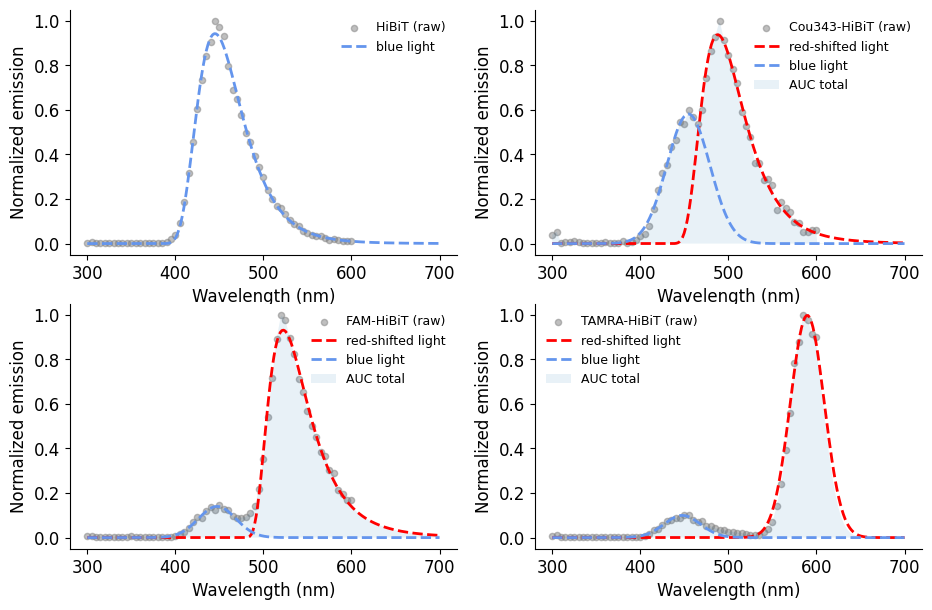

,sample,AUC total,AUC red,AUC blue,BRET efficiency,BRET ratio
0,HiBiT,NaN,NaN,66.551564,NaN,NaN
1,Cou343-HiBiT,83.438019,64.549093,35.657949,0.773617,1.810230
2,FAM-HiBiT,70.142568,61.595568,7.467206,0.878148,8.248811
3,TAMRA-HiBiT,51.402871,48.252315,5.169885,0.938709,9.333344


In [3]:
data_path = '../data/spectra_fluor_nanobits.csv'

fit_range_map = {
    'HiBiT': (300, 700),
    'Cou343-HiBiT': (465, 700),
    'FAM-HiBiT': (450, 700),
    'TAMRA-HiBiT': (570, 700)
}

bret_df = calculate_BE_MR_and_plot(data_path, fit_range_map, figsize=(11, 7), blue_range=(400, 465), full_range=(300, 700), save_path = '../figure/BRET/fluor_nanobits.pdf')
bret_df


# TAMTA-linker-NanoBiTs

/Users/suongsuong/Documents/GitHub/NanoBiT-BRET/notebook/../utils/BRET_efficiency.py:56: RuntimeWarning: invalid value encountered in log
  output[valid] = Im * np.exp(-(ln2 / denom) * (np.log(ratio) ** 2))


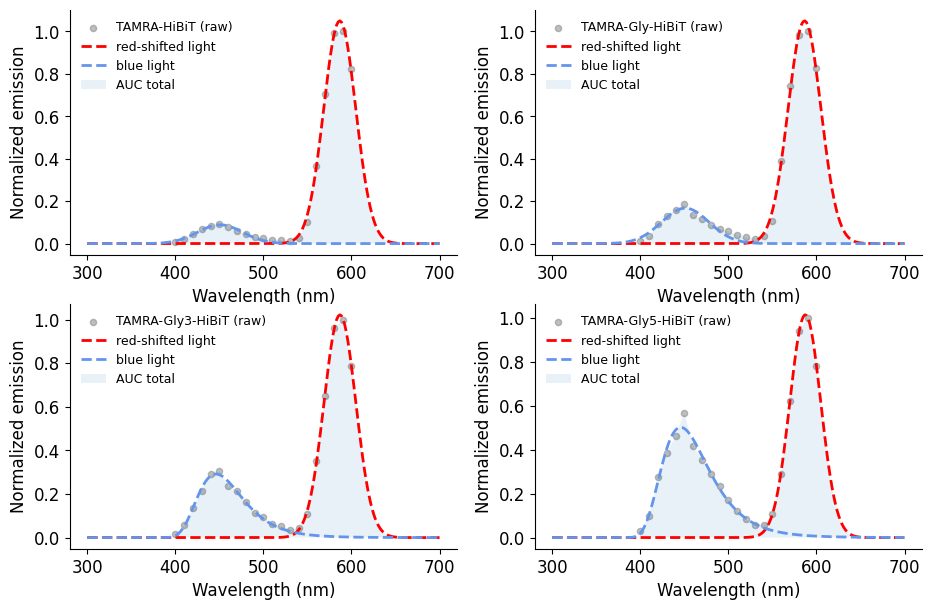

,sample,AUC total,AUC red,AUC blue,BRET efficiency,BRET ratio
0,TAMRA-HiBiT,53.070364,47.863899,5.675595,0.901895,8.433283
1,TAMRA-Gly-HiBiT,59.926768,49.029469,11.273083,0.818156,4.349251
2,TAMRA-Gly3-HiBiT,65.669344,46.252868,20.256874,0.704330,2.283317
3,TAMRA-Gly5-HiBiT,79.924385,44.747144,37.050997,0.559868,1.207718


In [4]:
data_path = '../data/spectra_fluor_linker_nanobits.csv'


fit_range_map = {
    'TAMRA-HiBiT': (520, 700),
    'TAMRA-Gly-HiBiT': (520, 700),
    'TAMRA-Gly3-HiBiT': (520, 700),
    'TAMRA-Gly5-HiBiT': (520, 700),
}

bret_df = calculate_BE_MR_and_plot(data_path, fit_range_map, figsize=(11, 7),blue_range=(400, 500), full_range=(300, 700),
save_path = '../figure/BRET/tamra_linker_nanobits.pdf')
bret_df


# QD-NanoBiTs

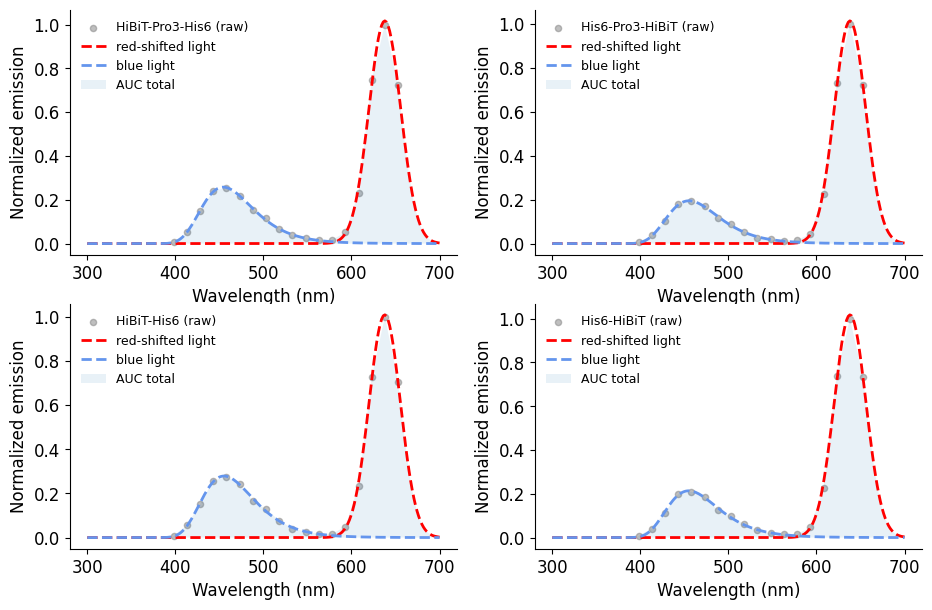

,sample,AUC total,AUC red,AUC blue,BRET efficiency,BRET ratio
0,HiBiT-Pro3-His6,65.300642,45.937654,20.284352,0.703479,2.264684
1,His6-Pro3-HiBiT,59.705993,45.259659,15.243587,0.758042,2.969095
2,HiBiT-His6,66.129011,44.955625,21.984080,0.679817,2.044917
3,His6-HiBiT,62.018120,46.031668,16.844558,0.742229,2.732732


In [5]:
data_path = '../data/spectra_quantum_dots_nanobits.csv'

fit_range_map = {
    'HiBiT-Pro3-His6': (530, 700),
    'His6-Pro3-HiBiT': (530, 700),
    'HiBiT-His6': (530, 700),
    'His6-HiBiT': (530, 700),
}


bret_df = calculate_BE_MR_and_plot(data_path, fit_range_map, figsize=(11, 7), blue_range=(400, 550), full_range=(300, 750), 
save_path = '../figure/BRET/QD_nanobits.pdf')

bret_df
